In [17]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import os
from glob import glob
from functools import reduce

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def rcollapse(arr, sep=" "):
    try:
        sep=str(sep)
        results = reduce(lambda x,y: '{}{}{}'.format(x,sep, y), arr)
    except Exception as e:
        print(e)
        results=None
    finally:
        return(results)

In [3]:
path = 'H:/Documents/Training/Thinkful'
f = 'crime.csv'

os.chdir('H:/Documents/Training/Thinkful')

In [4]:
d = pd.read_csv('crime.csv')

In [5]:
md = pd.DataFrame()
md['org'] = d.columns
md['label'] = ['city', 'population', 'violent',
               'murder', 'rape1', 'rape2',
               'robbery', 'assault', 'property',
               'burglary', 'larceny', 'auto', 'arson']
# md

In [6]:
norm = d.copy()
norm.columns = md.label
norm.columns.name=None
norm['murder_bin'] = norm.murder>0
norm['robbery_bin'] = norm.robbery>0
norm.loc[:, 'violent':'arson'] = norm.loc[:, 'population':'arson'].apply(lambda x: (x/norm.population)*100000)
norm.columns

Index(['city', 'population', 'violent', 'murder', 'rape1', 'rape2', 'robbery',
       'assault', 'property', 'burglary', 'larceny', 'auto', 'arson',
       'murder_bin', 'robbery_bin'],
      dtype='object')

In [7]:
print(norm.apply(lambda x: sum(x.isna())))
print(norm.shape)

city             0
population       0
violent          0
murder           0
rape1          348
rape2            0
robbery          0
assault          0
property         0
burglary         0
larceny          0
auto             0
arson          161
murder_bin       0
robbery_bin      0
dtype: int64
(348, 15)


In [8]:
from functools import reduce
drp = ['rape1']
matches = list(filter(lambda x: x in drp, norm.columns))
if len(matches)>0:
    norm.drop(matches, axis=1, inplace=True)
norm.columns

Index(['city', 'population', 'violent', 'murder', 'rape2', 'robbery',
       'assault', 'property', 'burglary', 'larceny', 'auto', 'arson',
       'murder_bin', 'robbery_bin'],
      dtype='object')

#### Correlation analysis
Property crime has too high a correlation to larceny--pearson coefficient = 0.99--for me to think that it's real. They're probably going to be nearly synonymous. Burglary is also highly correlated, with a Pearson coefficient of 0.78. In addition, there are 8 pairs of highly correlated variables that do not include property. Taking out 'robbery' and 'violent crime' might cut down significantly on colinearity between variables.

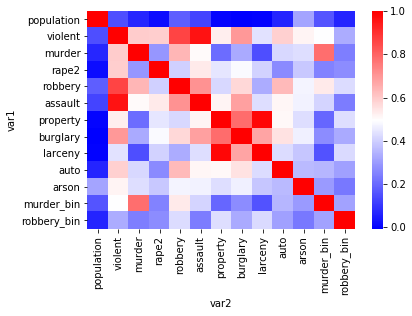

,var1,var2,correlation
66,violent,assault,0.964336
53,violent,robbery,0.862699
92,violent,burglary,0.699370
69,robbery,assault,0.710264
30,robbery,murder,0.639665
121,robbery,auto,0.630768
110,property,larceny,0.985987
97,property,burglary,0.787320
37,murder_bin,murder,0.782663
99,larceny,burglary,0.676478


In [9]:
nc = norm.drop('city', axis=1).corr()
nc.index.name='var1'
nc.columns.name='var2'

sns.heatmap(nc, cmap='bwr')
plt.show()

long = nc.reset_index().melt(id_vars='var1', value_name='correlation', var_name='var2')
long.loc[(long.correlation >=0.6) &
         (long.correlation < 1) &
         (long.var1>long.var2)].sort_values(['var1', 'correlation'], ascending=False)

In [12]:
nc['property'].sort_values(ascending=False)

var1
property       1.000000
larceny        0.985987
burglary       0.787320
violent        0.531994
assault        0.517531
auto           0.508681
rape2          0.449445
arson          0.432694
robbery_bin    0.431294
robbery        0.419695
murder         0.209125
murder_bin     0.197976
population     0.001928
Name: property, dtype: float64

#### Outlier Analysis

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


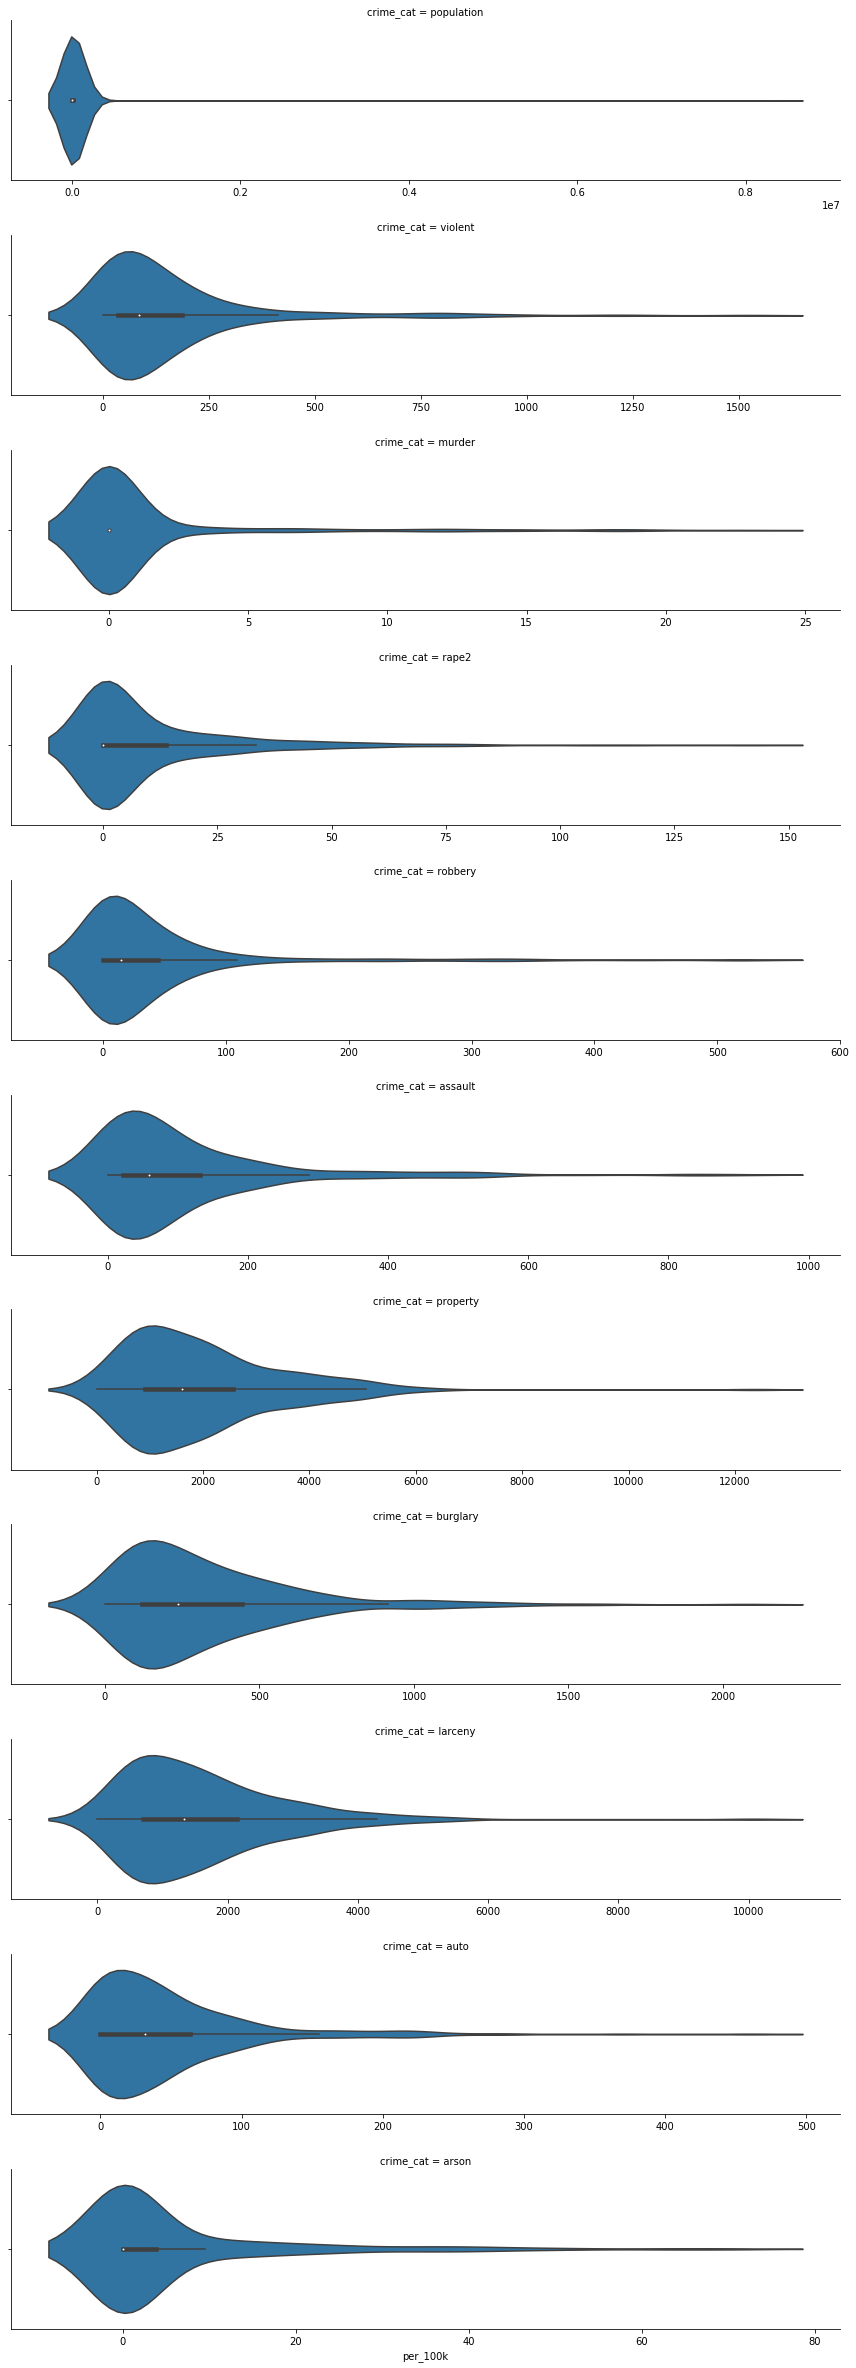

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


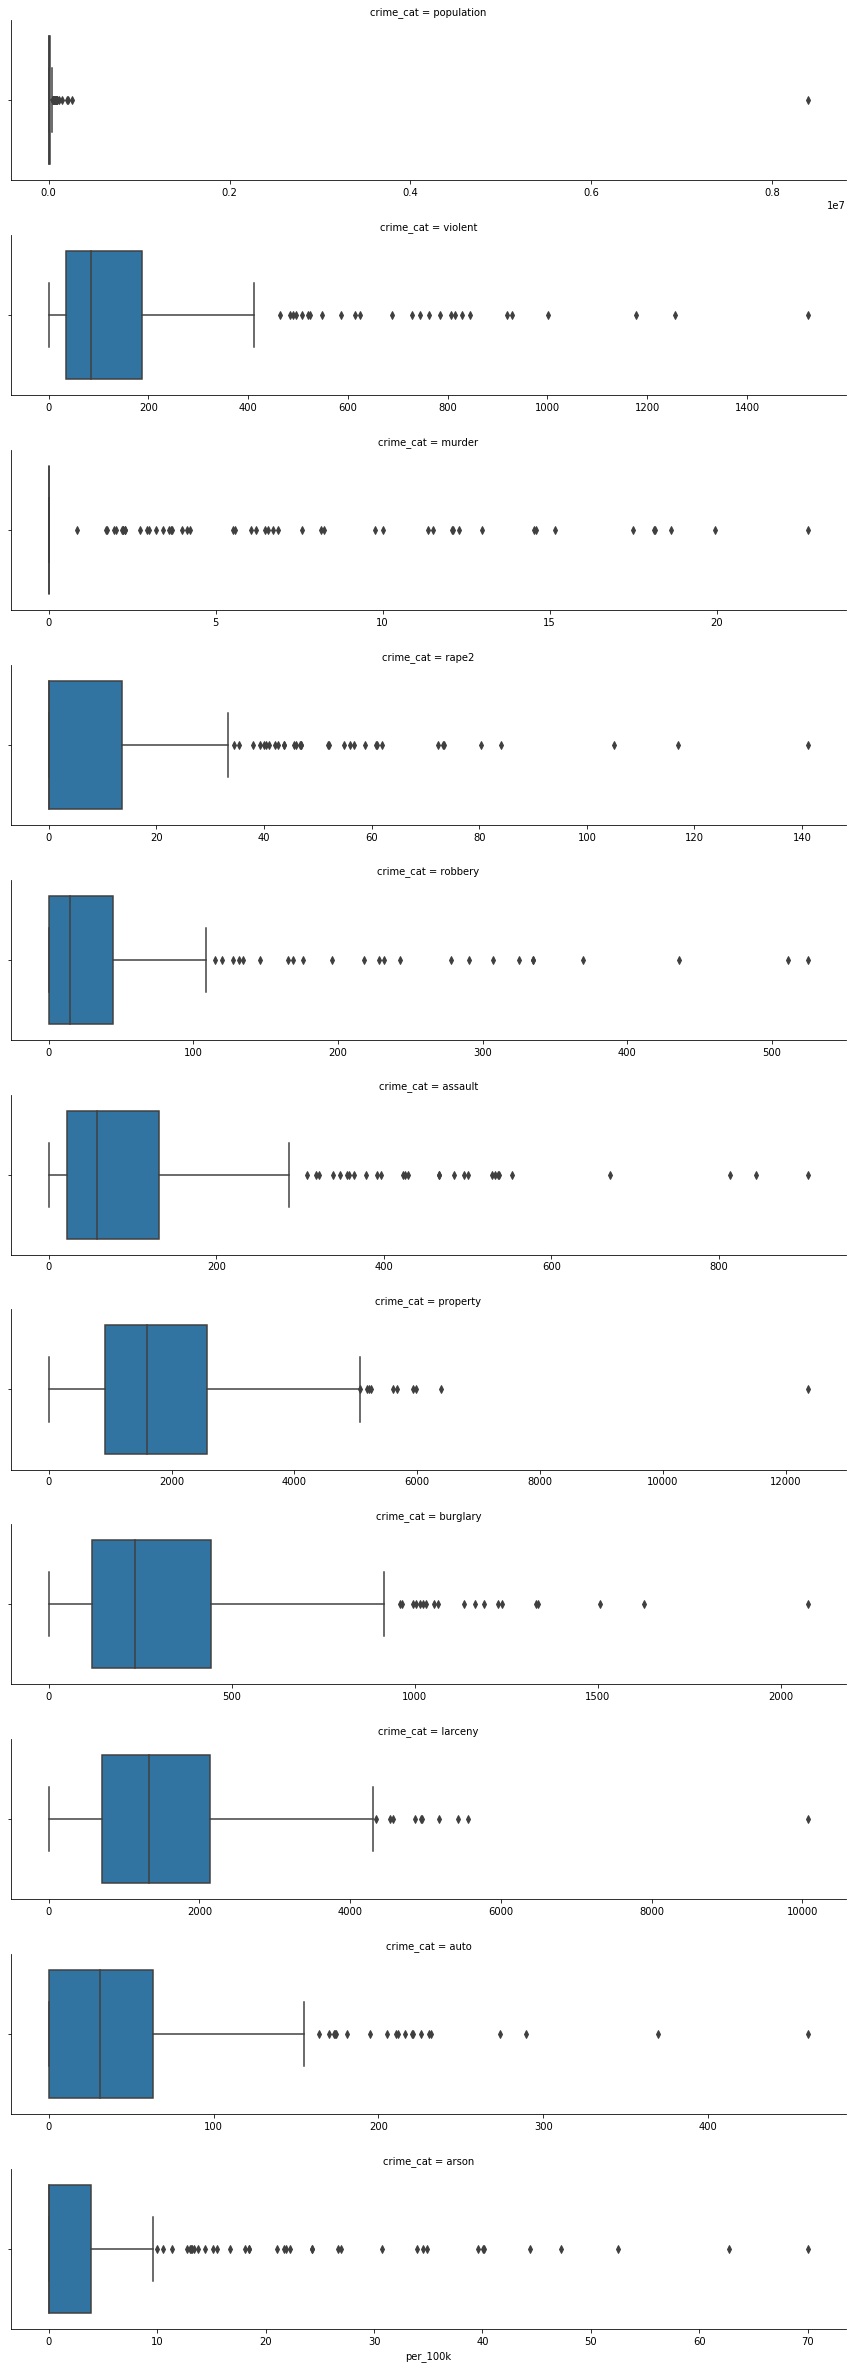

In [10]:
#  Violin plots
d_viol = norm.loc[:, 'population':'arson'].melt(var_name='crime_cat', value_name='per_100k')

g = sns.FacetGrid(d_viol, row='crime_cat', sharex=False, aspect=4)
g.map(sns.violinplot, 'per_100k')
plt.show()

g = sns.FacetGrid(d_viol, row='crime_cat', sharex=False, aspect=4)
g.map(sns.boxplot, 'per_100k')

In [11]:
outliers = {'violent': [1400, 1100],
           'rape2': [100, 70],
           'robbery': [500, 400],
           'assault': [700, 600],
           'property': [10000],
           'burglary': [2000, 1450],
           'larceny': [10000],
           'auto': [260]}

outl = pd.DataFrame({'label': [x[0] for x in outliers.items()],
              'low_outlier': [min(x[1]) for x in outliers.items()],
              'high_outlier': [max(x[1]) for x in outliers.items()]})
md = pd.merge(md, outl, left_on='label', right_on='label', how='left')

In [12]:
for r in md.loc[~(md.low_outlier.isna())].index:
    lab = md.loc[r, 'label']
    norm['{0}_outlier'.format(lab)] = norm[lab]>=md.loc[r, 'low_outlier']

## Final Decisions
Retained features
- Rape, definition 2
- Violent crime
- Murder

Outliers were also dropped as defined below.

In [13]:
feat = norm.loc[:, ['violent', 'murder', 'rape2', 'property']]

#### Univariate distributions

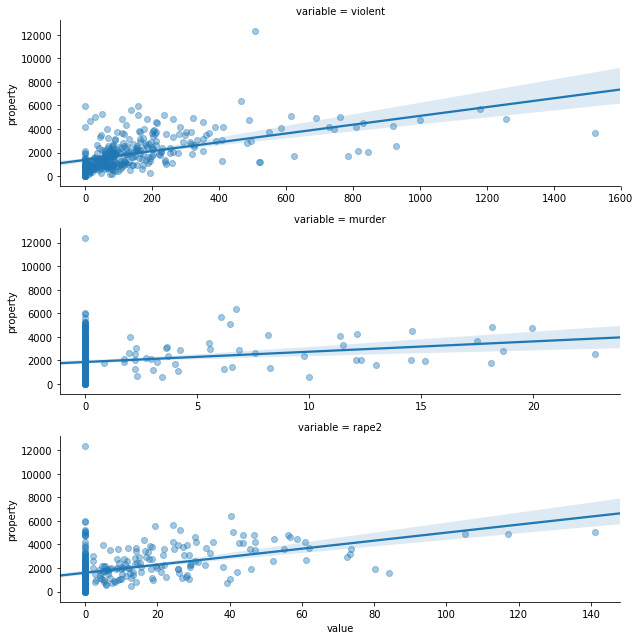

In [15]:
l = feat.melt(id_vars='property')
g = sns.FacetGrid(l, row='variable', aspect=3, sharex=False)
g.map(sns.regplot, 'value', 'property', scatter_kws={'alpha':0.4})
plt.show()

In [20]:
mod = ols("property ~ rape2+murder+violent", data=feat).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               property   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     55.26
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           3.52e-29
Time:                        22:38:28   Log-Likelihood:                -2960.4
No. Observations:                 348   AIC:                             5929.
Df Residuals:                     344   BIC:                             5944.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1318.6202     81.278     16.224      0.0

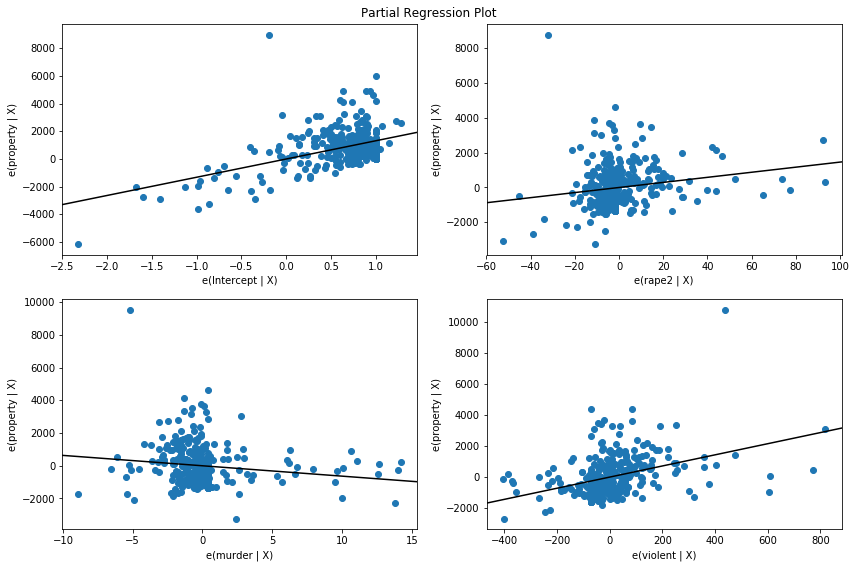

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
plt.show()

## Model 2: eliminate property outlier
Eliminating the unusually high property value led to a better model, as determined by the higher R2 and adjusted R2 scores.

In [52]:
out = norm.loc[list(filter(lambda x: x!= 289, norm.index))]

In [53]:
mod = ols("property ~ rape2+murder+violent", data=out).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               property   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     61.08
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.16e-31
Time:                        23:03:11   Log-Likelihood:                -2918.8
No. Observations:                 347   AIC:                             5846.
Df Residuals:                     343   BIC:                             5861.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1327.1094     73.888     17.961      0.0